In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
import keras.backend as k 
from tensorflow import keras 

In [2]:
def yolo_filter_boxes(convidence,boxes,classes_prob,threshold=0.6):
    """
    this perform a filter based on box_score and exclude boxes with score lower than 0.6 

    arguments:
    convidence -- probility of being an object inside box , shape = (52,52,5,1)
    boxes -- array containig all boxes cordiante , boxes create by yolo algorithm , shape = (52,52,5,4)
    classes_prob -- array containig all classes prob for each anchor box , shape = (52,52,5,80)
    threshold -- boundary for exclude probinility 

    returns:
    scores -- scores of each selected boxes by the filter 
    boxes -- cordinate of selected boxes 
    classes -- label with the high score for each selected boxes 
    
    """
    scores = tf.math.multiply(convidence,classes_prob)
    max_scores = k.max(scores,axis=-1)
    mask = max_scores >= threshold 
    classes = k.argmax(scores,axis=-1)
    #print(mask.shape , classes.shape)
    a = tf.boolean_mask(tensor=max_scores,mask=mask)
    b = tf.boolean_mask(boxes,mask)
    c = tf.boolean_mask(classes,mask)
    return  a ,b  ,c 

In [3]:
with tf.compat.v1.Session() as test_a:
    box_confidence = tf.random.normal([52, 52, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random.normal([52, 52, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random.normal([52, 52, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))
    #print(np.array(boxes.eval()).shape)


scores[2] = 10.750582
boxes[2] = [-1.8915889   0.7749185   3.5741792  -0.05729628]
classes[2] = 21
scores.shape = (None,)
boxes.shape = (None, 4)
classes.shape = (None,)


In [4]:
def iou(bx1,bx2):
    """
    this perform intersept over union , we use this later in Non_max_suppression algorithm 

    arguments:
    bx1 -- list of (xlt_1 , ylt_1 , xrb_1 , yrb_1) represent a box with contatinig its two caordinate lefttop and rightbottom 
    bx2 --  list of (xlt_2 , ylt_2 , xrb_2 , yrb_2) represent a box with contatinig its two caordinate lefttop and rightbottom 

    return :
    iot -- a value between 0 and 1 represent intersection over union 
    """

    (xlt_1 , ylt_1 , xrb_1 , yrb_1) = bx1
    (xlt_2 , ylt_2 , xrb_2 , yrb_2) = bx2

    print(xlt_1 , ylt_1 , xrb_1 , yrb_1)
    print(xlt_2 , ylt_2 , xrb_2 , yrb_2)
    xi1 = max(xlt_1 , xlt_2)
    yi1 = max(ylt_1 , ylt_2)
    xi2 = min(xrb_1,xrb_2)
    yi2 = min(yrb_1,yrb_2)

    height = yi2 - yi1
    widght = xi2 - xi1

    intersept = max(height,0) * max(widght,0)
    union = (xrb_1 - xlt_1) * (yrb_1 - ylt_1) + (xrb_2 - xlt_2) * (yrb_2 - ylt_2) - intersept 

    iot = intersept / union 

    return iot 

In [5]:
## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou for intersecting boxes = " + str(iou(box1, box2)))

## Test case 2: boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))

## Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))

## Test case 4: boxes intersect at edge only
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))

2 1 4 3
1 2 3 4
iou for intersecting boxes = 0.14285714285714285
1 2 3 4
5 6 7 8
iou for non-intersecting boxes = 0.0
1 1 2 2
2 2 3 3
iou for boxes that only touch at vertices = 0.0
1 1 3 3
2 3 3 4
iou for boxes that only touch at edges = 0.0


**Expected Output**:

```
iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0
```

In [6]:
def yolo_non_max_suppression(scores,boxes,classes,max_boxes=10,threshold=0.5):
    """
    this apply non_max suppression with help of tensorflow 

    arguments:
    boxes -- shape (num_boxes,4)
    scores -- shape(num_boxes)
    classes -- shape (num_boxes)
    max_boxes -- maximum number of boxes 
    threshold -- threshold for iot 

    return :
    boxes -- selected boxes
    scores -- scores of selected boxes 
    classses -- class of selected boxes 
    """
    indexies = tf.image.non_max_suppression(
        boxes,
        scores,
        max_output_size=max_boxes,
        iou_threshold=threshold,
    )
    
    classes_ = tf.gather(classes,indexies)
    boxes_ = tf.gather(boxes,indexies)
    scores_ = tf.gather(scores,indexies)

    return   scores_,boxes_ , classes_

In [7]:
with tf.compat.v1.Session() as test_b:
    scores = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [8]:
try:
    del read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
    del yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body 
except :
    pass

In [9]:
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body


In [10]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 52, 52, 5, 1)
                    box_xy: tensor of shape (None, 52, 52, 5, 2)
                    box_wh: tensor of shape (None, 52, 52, 5, 2)
                    box_class_probs: tensor of shape (None, 52, 52, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """

    convidence , box_xy , box_wh , box_class_probs = yolo_outputs

    boxes = yolo_boxes_to_corners(box_xy, box_wh) 

    scores , boxes , classes = yolo_filter_boxes(convidence,boxes,box_class_probs,score_threshold)

    boxes = scale_boxes(boxes, image_shape)
    
    scores,boxes  ,classes = yolo_non_max_suppression(scores,boxes,classes,max_boxes,iou_threshold)


    return scores , boxes ,  classes

    

In [11]:
with tf.compat.v1.Session() as test_b:
    yolo_outputs = (tf.random.normal([52, 52, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random.normal([52, 52, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random.normal([52, 52, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random.normal([52, 52, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 190.83098
boxes[2] = [ 4056.0027   295.2152 12168.008    885.6457]
classes[2] = 71
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [12]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

In [13]:
from keras.models import load_model, Model

In [14]:
yolo_model_ = load_model("model_data/yolo.h5")

In [15]:
yolo_model_.layers[-4].output

<KerasTensor: shape=(None, 52, 52, 255) dtype=float32 (created by layer 'conv2d_75')>

In [16]:
yolo_model = keras.Model(inputs=yolo_model_.input ,outputs= yolo_model_.layers[-4].output)

In [17]:
yolo_outputs = [list(yolo_head(yolo_model.output, anchors, len(class_names)))[i] for i in [2,1,0,3]]

In [18]:
yolo_outputs

[<KerasTensor: shape=(None, 52, 52, 3, 1) dtype=float32 (created by layer 'tf.math.sigmoid_1')>,
 <KerasTensor: shape=(None, 52, 52, 3, 2) dtype=float32 (created by layer 'tf.math.truediv_3')>,
 <KerasTensor: shape=(None, 52, 52, 3, 2) dtype=float32 (created by layer 'tf.math.truediv_4')>,
 <KerasTensor: shape=(None, 52, 52, 3, 80) dtype=float32 (created by layer 'tf.nn.softmax_3')>]

In [19]:
image_shape = (720., 1280.)  
scores , boxes , classes = yolo_eval(yolo_outputs,image_shape )

In [20]:
final_yolo = keras.Model(yolo_model.input , outputs = [scores , boxes , classes])

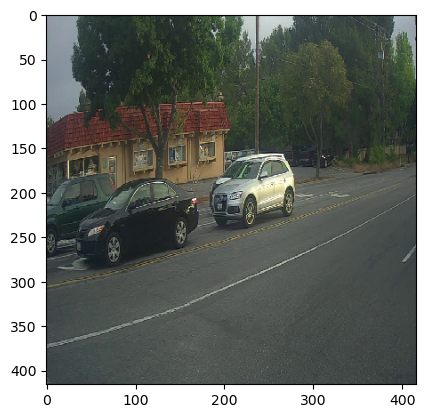

In [21]:
image = keras.preprocessing.image
img = image.load_img("images/0059.jpg",target_size=(416,416,3))
img1 = image.img_to_array(img)
plt.imshow(img1.astype(np.int64))

In [22]:
img.size

(416, 416)

In [23]:
scores , boxes , classes = final_yolo.predict(np.expand_dims(img1,axis=0))

1/1 [==============================] - 3s 3s/step


In [24]:
boxes

array([[ -14.096607 , -608.9642   ,   25.586716 ,  614.79004  ],
       [   3.9551318,  -71.9928   ,   49.74332  ,  557.7604   ],
       [  -2.1668239,   43.870087 ,   31.166079 ,  679.43365  ]],
      dtype=float32)

In [25]:
image, image_data = preprocess_image("images/0059.jpg" , model_image_size = (416, 416))

In [26]:
image_data.shape

(1, 416, 416, 3)

In [27]:
import os 
type(image_data)

numpy.ndarray

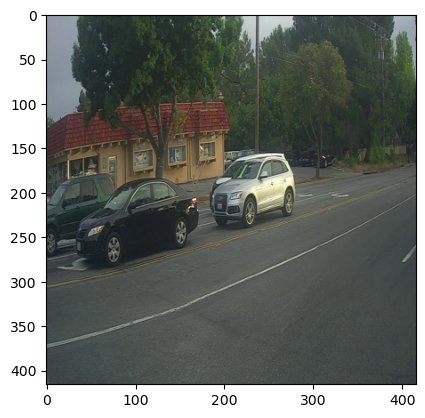

In [28]:
plt.imshow(image_data[0])

In [31]:
def predict(image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """
    image_file = image_file + ".jpg"
    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (416, 416))
    img_handeler = keras.preprocessing.image
    arr_ = img_handeler.load_img("images/" + image_file , target_size=(416,416,3))
    arr = img_handeler.img_to_array(arr_)
    #plt.imshow(arr.astype(np.int64))
    
    out_scores, out_boxes, out_classes = final_yolo.predict(np.expand_dims(arr,axis=0))
    print(out_scores, out_boxes, out_classes)
    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    final_img = img_handeler.load_img(os.path.join("out", image_file))
    plt.imshow(final_img)
    
    return out_scores, out_boxes, out_classes

1/1 [==============================] - 0s 435ms/step
[0.9613507] [[-332.7016   -48.90119  340.93375   65.86597]] [65]
Found 1 boxes for 0009.jpg
remote 0.96 (0, 0) (66, 341)


(array([0.9613507], dtype=float32),
 array([[-332.7016 ,  -48.90119,  340.93375,   65.86597]], dtype=float32),
 array([65], dtype=int64))

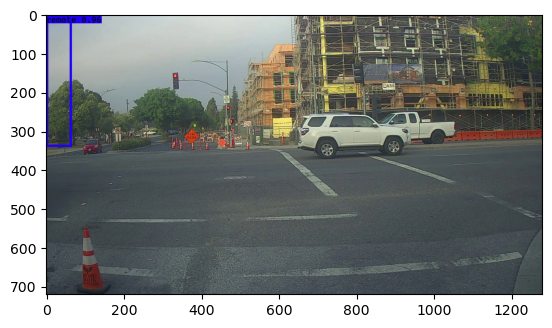

In [33]:
predict("0009")

so  i think an bug has accure 